In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing the necessary lib
import pandas as pd
import seaborn as sns
import numpy as np
import sqlite3
import os
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix,classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV,KFold
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer,one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, BatchNormalization,concatenate,Flatten,MaxPool2D,Embedding,Dense,Dropout,MaxPooling2D,Reshape,BatchNormalization
from keras.models import Sequential
from keras import Model,Input
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,Conv1D
import keras.backend as k
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score,f1_score,log_loss,recall_score,classification_report
import tensorflow as tf
from keras.callbacks import Callback, EarlyStopping
from time import time
from scipy.sparse import hstack
from tensorflow.python.keras.callbacks import TensorBoard
import pickle
from keras.optimizers import Adam,SGD,RMSprop
from keras.initializers import RandomUniform,he_uniform,glorot_normal
from keras.regularizers import l1
from keras.models import Sequential
from keras.layers import LSTM,BatchNormalization
from tensorflow.keras.layers import Dense, Dropout
import datetime
from prettytable import PrettyTable
from hyperopt import Trials, STATUS_OK, tpe
!pip install hyperas
from hyperas import optim
from hyperas.distributions import choice, uniform,pchoice
from keras.utils import to_categorical
from keras.regularizers import l1
import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.4 MB/s eta 0:00:00


In [ ]:
#Reading the train, test and CV data
train = pd.read_csv('/content/drive/MyDrive/TEP Dataset/train.csv')
cv = pd.read_csv("/content/drive/MyDrive/TEP Dataset/cv.csv")
test = pd.read_csv("/content/drive/MyDrive/TEP Dataset/test.csv")
train.head()
print(train.shape)

(260000, 56)


In [ ]:
# Removing faults 3, 5, 8, 9, 10, 12, 15, 16, and 18.
tr = train.drop(train[(train.faultNumber == 3) | (train.faultNumber == 9) | (train.faultNumber == 15) | (train.faultNumber == 5) | (train.faultNumber == 8) | (train.faultNumber == 10) | (train.faultNumber == 12) | (train.faultNumber == 16) | (train.faultNumber == 18)].index).reset_index()
ts = test.drop(test[(test.faultNumber == 3) | (test.faultNumber == 9) | (test.faultNumber == 15) | (test.faultNumber == 5) | (test.faultNumber == 8) | (test.faultNumber == 10) | (test.faultNumber == 12) | (test.faultNumber == 16) | (test.faultNumber == 18)].index).reset_index()
cv_ = cv.drop(cv[(cv.faultNumber == 3) | (cv.faultNumber == 9) | (cv.faultNumber == 15) | (cv.faultNumber == 5) | (cv.faultNumber == 8) | (cv.faultNumber == 10) | (cv.faultNumber == 12) | (cv.faultNumber == 16) | (cv.faultNumber == 18)].index).reset_index()

In [ ]:
tr_1 = tr
ts_1 = ts
cv_1 = cv_

In [ ]:
# Map fault numbers to a new continuous range
mapping = {0:0, 1:1, 2:2, 4:3, 6:4, 7:5, 11:6, 13:7, 14:8, 17:9, 19:10, 20:11}
tr['mappedFaultNumber'] = tr['faultNumber'].map(mapping)
ts['mappedFaultNumber'] = ts['faultNumber'].map(mapping)
cv_['mappedFaultNumber'] = cv_['faultNumber'].map(mapping)

In [ ]:
# Map fault numbers to a new continuous range
mapping = {0:0, 1:1, 2:2, 4:3, 6:4, 7:5, 11:6, 13:7, 14:8, 17:9, 19:10, 20:11}
tr_1['mappedFaultNumber'] = tr_1['faultNumber'].map(mapping)
ts_1['mappedFaultNumber'] = ts_1['faultNumber'].map(mapping)
cv_1['mappedFaultNumber'] = cv_1['faultNumber'].map(mapping)

In [ ]:
y_train_1 = tr_1['mappedFaultNumber'].values
y_test_1 = ts_1['mappedFaultNumber'].values
y_cv_1 = cv_1['mappedFaultNumber'].values

# Column names to drop
columns_to_drop = ['faultNumber', 'Unnamed: 0', 'simulationRun', 'sample', 'index', 'mappedFaultNumber']

# Extend the list with column names from index 27 to 45
# Note: Python uses 0-based indexing, and the range end is exclusive, so we use 46
columns_to_drop.extend(tr.columns[27:46])

# Drop the columns from the dataframes
tr_1.drop(columns_to_drop, axis=1, inplace=True)
ts_1.drop(columns_to_drop, axis=1, inplace=True)
cv_1.drop(columns_to_drop, axis=1, inplace=True)

In [ ]:
print(y_train_1.shape)

(152000,)


In [ ]:
standard_scalar = StandardScaler()
train_norm = standard_scalar.fit_transform(tr_1)
test_norm = standard_scalar.transform(ts_1)
cv_norm = standard_scalar.transform(cv_1)

In [ ]:
# model fitting and hyperparameter tuning using gridsearch
x_cfl=RandomForestClassifier()
#weights = np.linspace(0.05, 0.95, 20)
prams={
     'n_estimators':[100,200,500],
     'max_depth':[15,20,25,30,35]#,'class_weight': [{0: x, 1: 1.0-x} for x in weights]


}
model=GridSearchCV(x_cfl,param_grid=prams,verbose=10,n_jobs=-1,scoring='f1_micro',cv=3)
model.fit(train_norm,y_train_1)
print("Best estimator is", model.best_params_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best estimator is {'max_depth': 35, 'n_estimators': 500}


In [ ]:
clf = RandomForestClassifier(n_jobs=-1,n_estimators= 500,max_depth=35)
clf.fit(train_norm, y_train_1)

RandomForestClassifier(max_depth=35, n_estimators=500, n_jobs=-1)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Define your custom class labels
custom_labels = ['0', '1', '2', '4', '6', '7', '11', '13', '14', '17', '19', '20']

# Create a function to plot the confusion matrix with custom labels
def plot_confusion_matrix_1(y_true, y_pred, title):
    f, ax = plt.subplots(figsize=(15, 15))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', ax=ax,
                xticklabels=custom_labels, yticklabels=custom_labels)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_ylim(len(cm), 0)
    plt.tight_layout()
    plt.show()

    f, ax = plt.subplots(figsize=(15, 15))
    precision = confusion_matrix(y_true, y_pred, normalize='pred')
    sns.heatmap(precision, annot=True, cmap='Blues', ax=ax,
                xticklabels=custom_labels, yticklabels=custom_labels)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_ylim(len(precision), 0)
    plt.tight_layout()
    plt.show()

    f, ax = plt.subplots(figsize=(15, 15))
    recall = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(recall, annot=True, cmap='Blues', ax=ax,
                xticklabels=custom_labels, yticklabels=custom_labels)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_ylim(len(recall), 0)
    plt.tight_layout()
    plt.show()


    trace = np.diag(precision)

     # Sum of the trace (the sum of the diagonal elements of the confusion matrix) gives total true positives
    total_true_positives = np.sum(trace)

# Calculate the aggregate precision including class '0'
# Divide the total true positives by the number of classes
    aggregate_precision_including = total_true_positives / len(custom_labels)
    print(f"Aggregate Precision (including all classes): {aggregate_precision_including:.3f}")

# Calculate the aggregate precision excluding class '0'
# Subtract the true positives of class '0' from the total true positives and divide by the number of classes minus one
    aggregate_precision_excluding = (total_true_positives - trace[0]) / (len(custom_labels) - 1)
    print(f"Aggregate Precision (excluding class '0'): {aggregate_precision_excluding:.3f}")

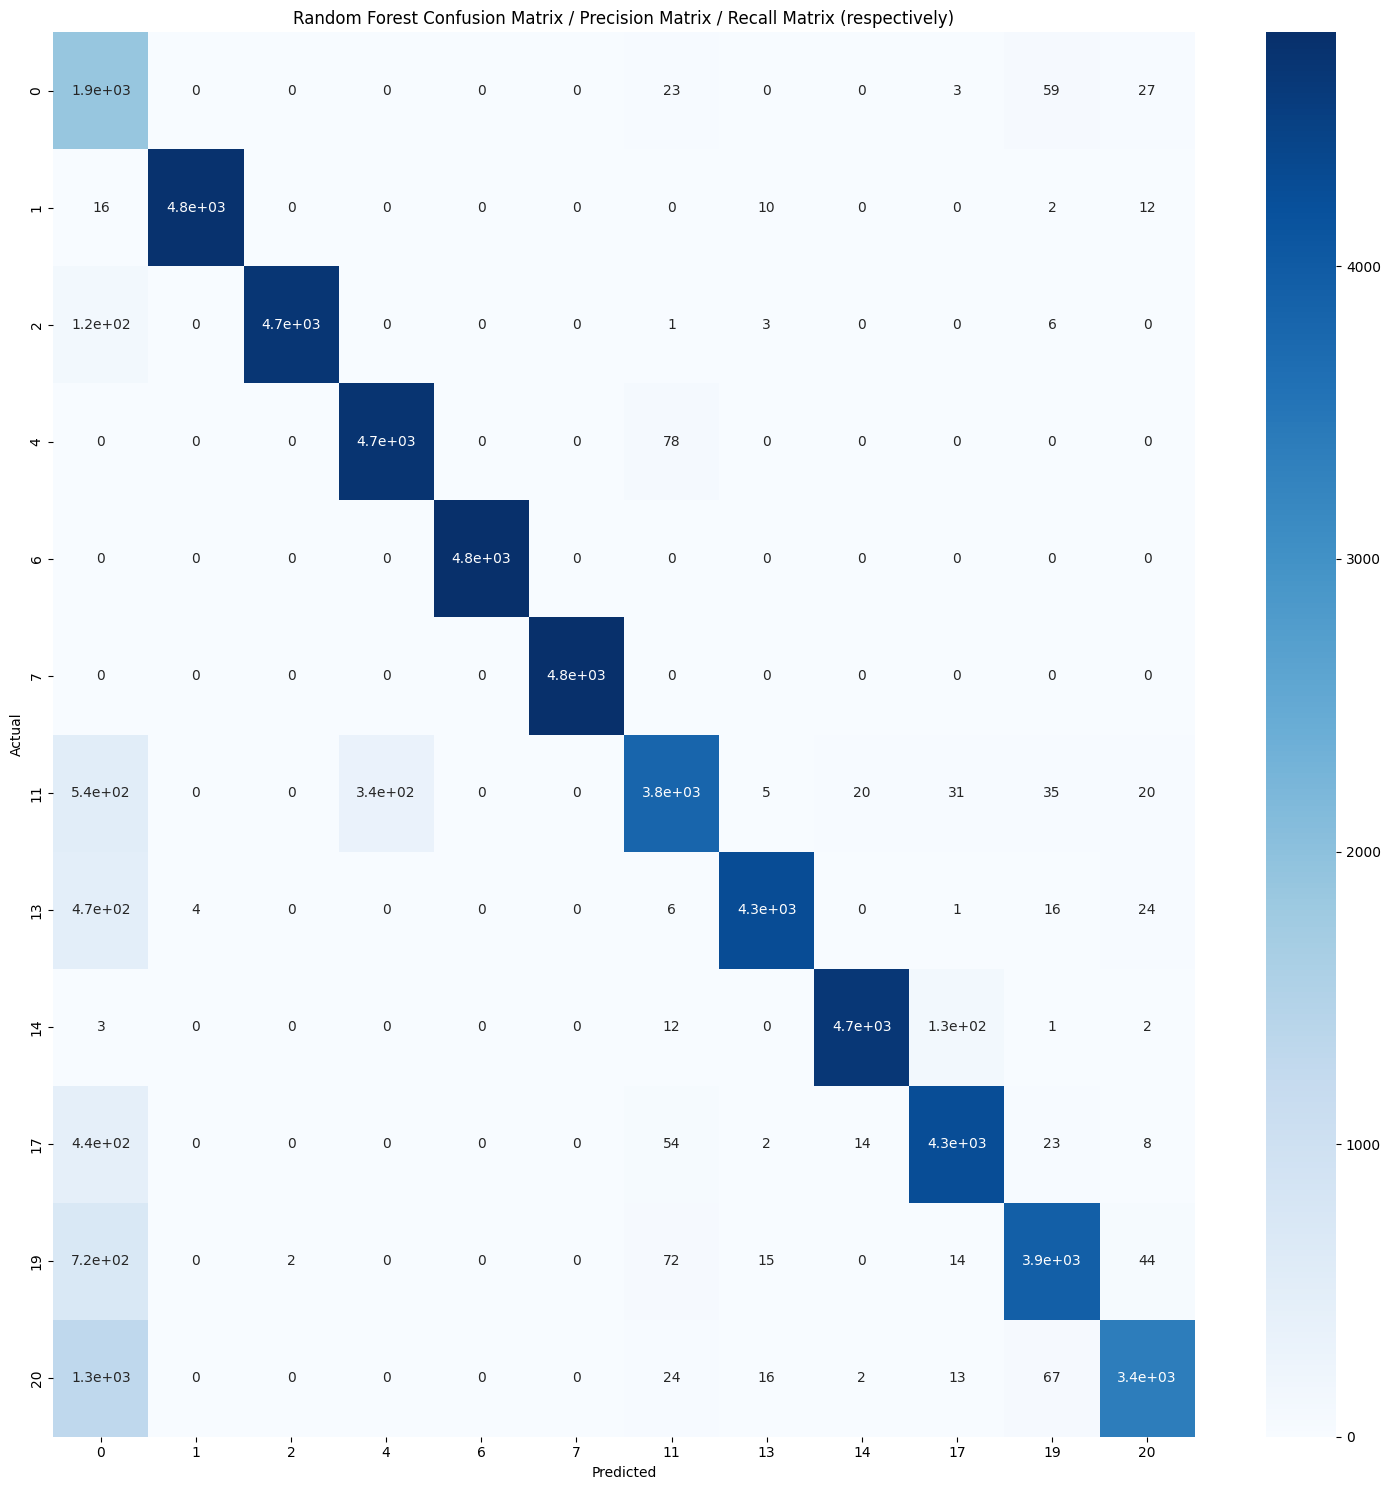

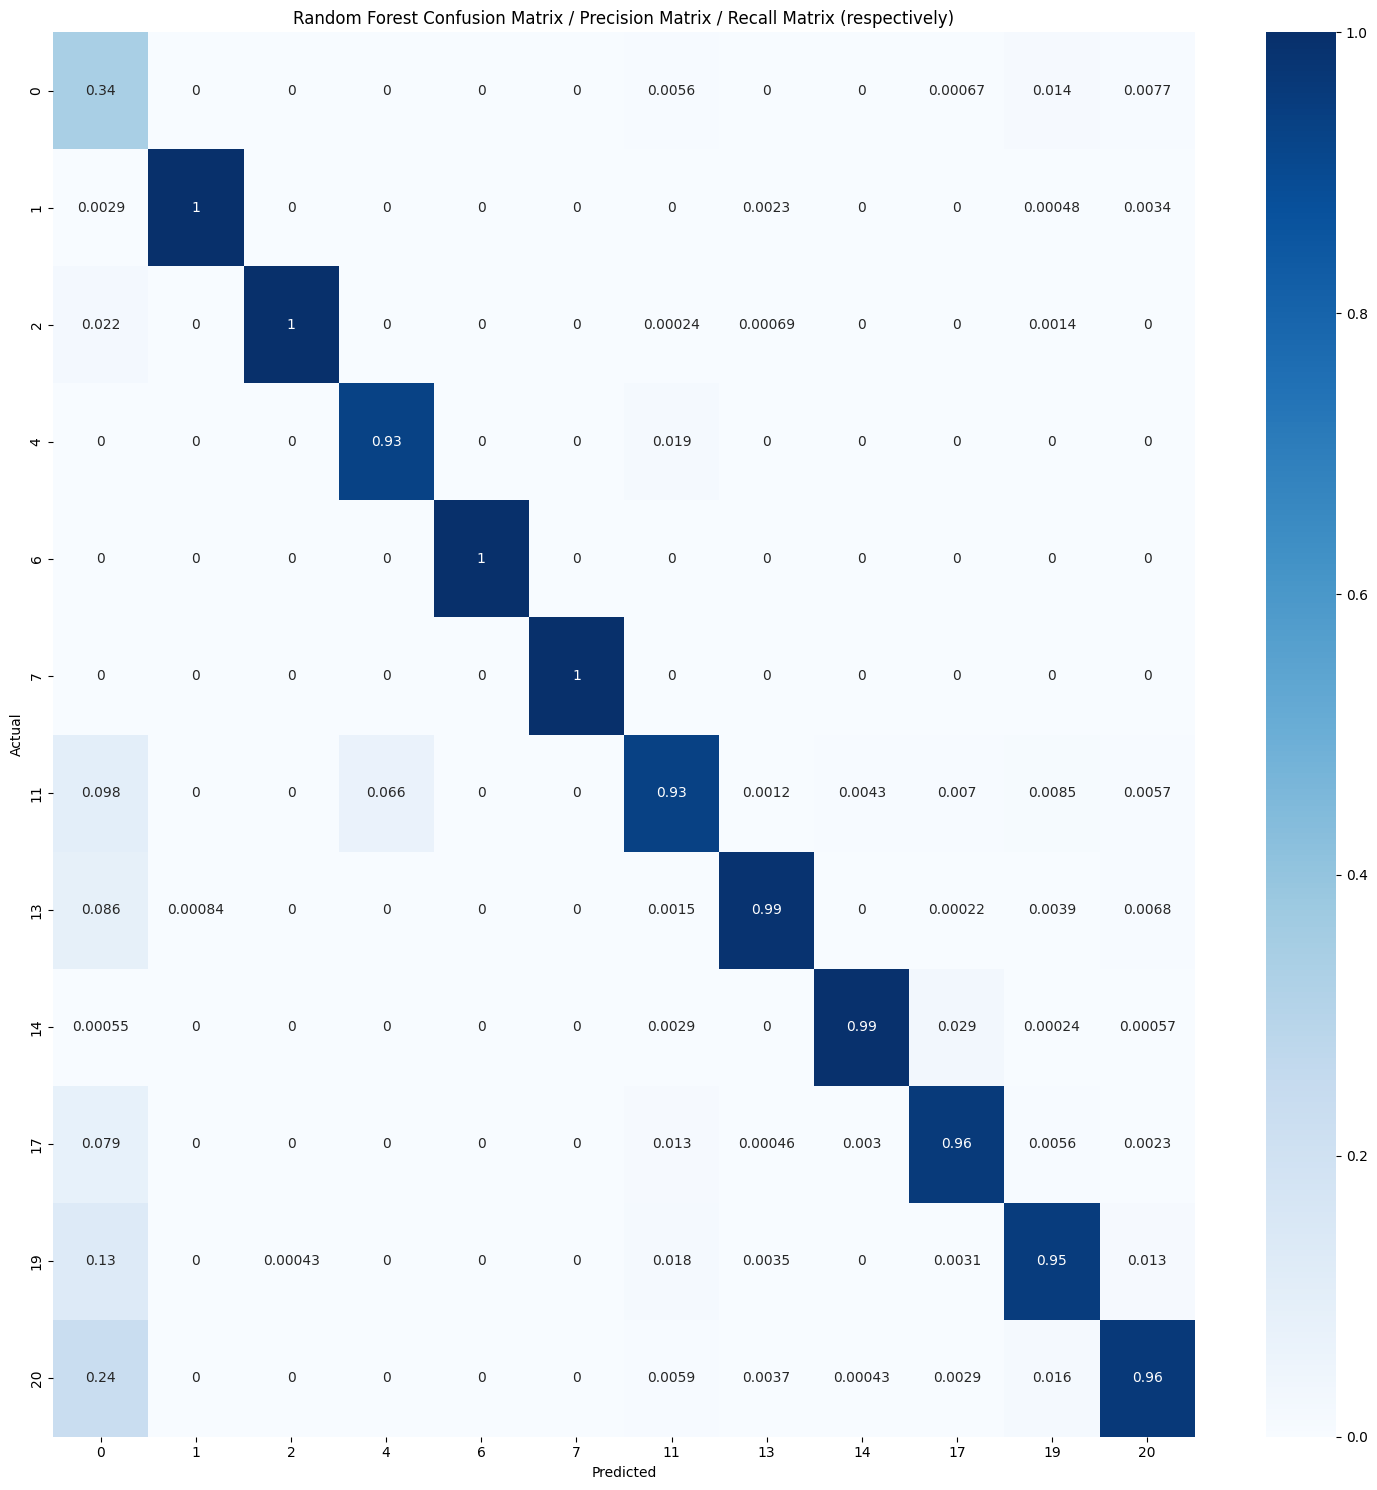

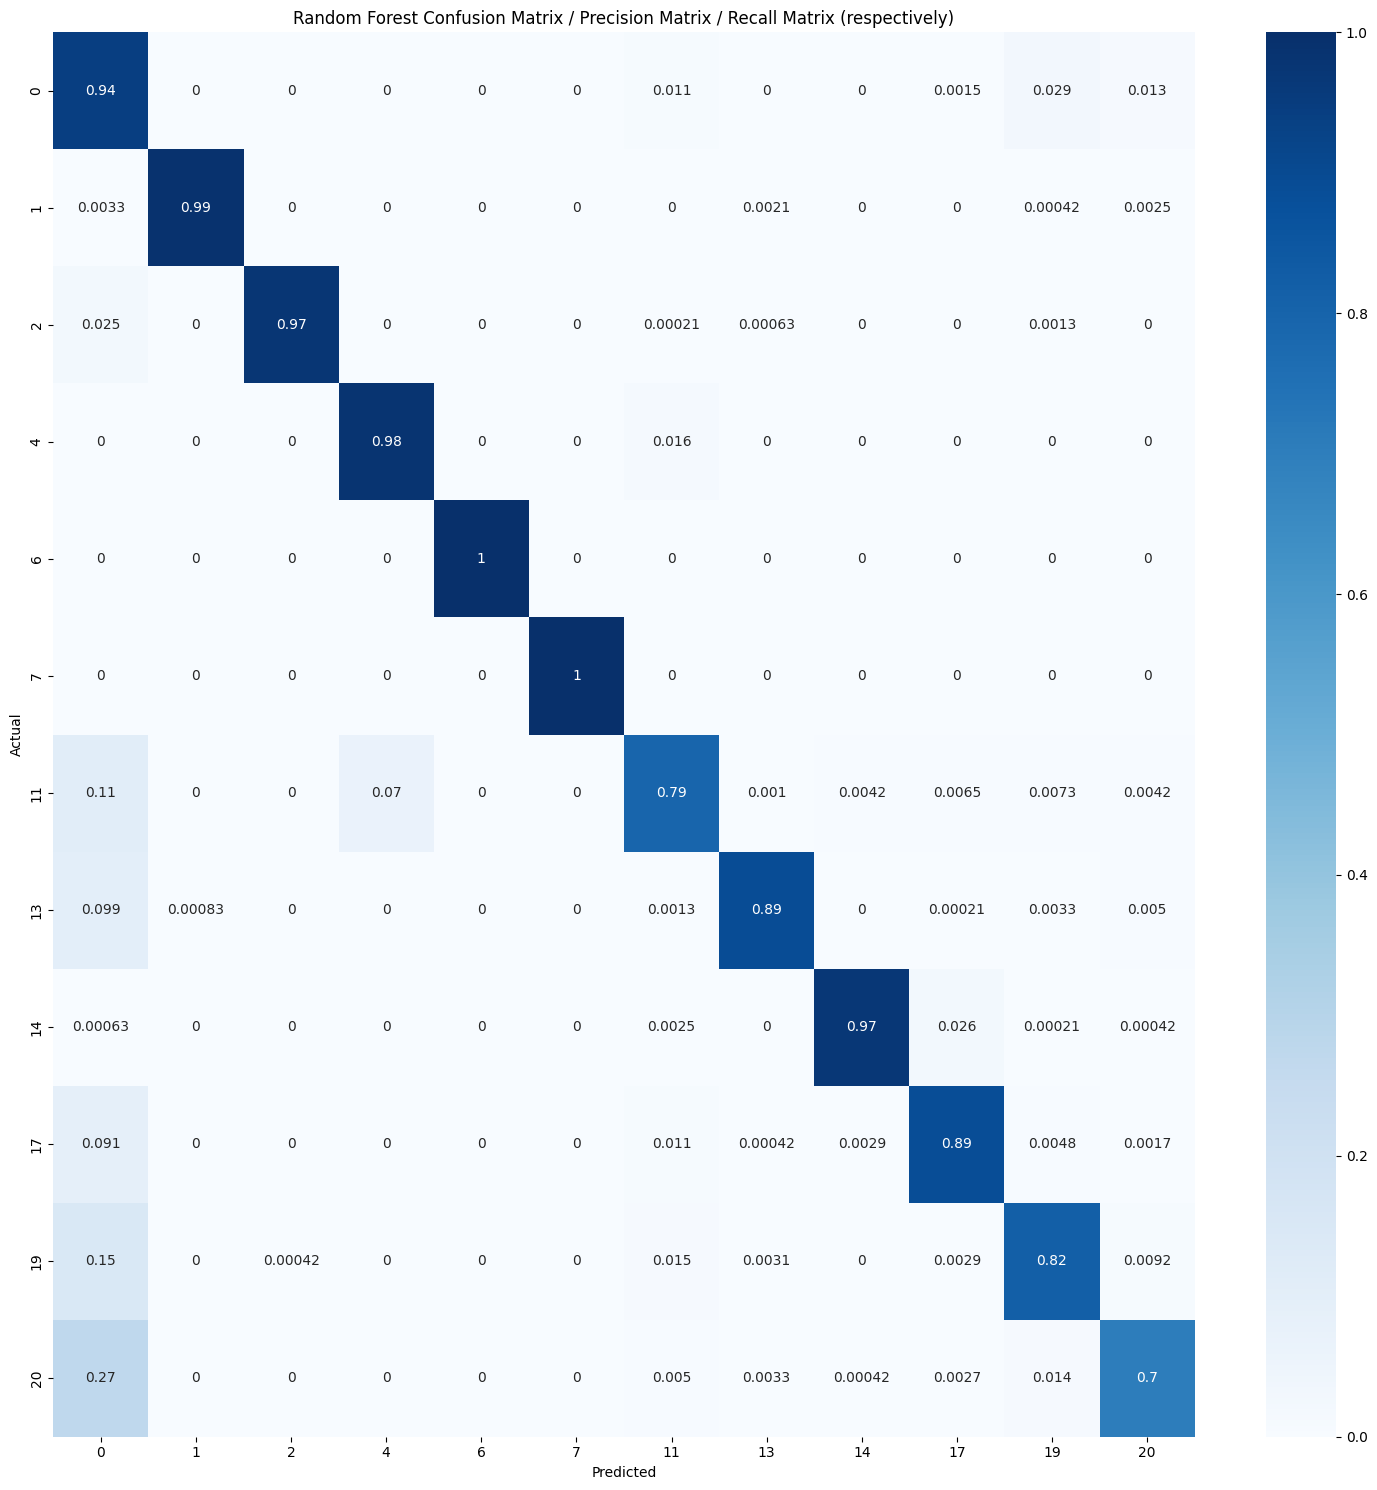

Aggregate Precision (including all classes): 0.922
Aggregate Precision (excluding class '0'): 0.974
Random Forest Classification accuracy_score: 0.9115510948905109


In [ ]:
plot_confusion_matrix_1(y_test_1, clf.predict(test_norm), 'Random Forest Confusion Matrix / Precision Matrix / Recall Matrix (respectively)')
print("Random Forest Classification accuracy_score:", accuracy_score(y_test_1, clf.predict(test_norm)))

In [ ]:
import pandas as pd
df = pd.DataFrame(clf.predict(test_norm))
df.to_csv('/content/drive/MyDrive/TEP Dataset/TEP and RFC prediction and y_test_1/RFCPredictions.csv', index = False)

In [ ]:
df_1 = pd.DataFrame(y_test_1)
df_1.to_csv('/content/drive/MyDrive/TEP Dataset/TEP and RFC prediction and y_test_1/y_test_1.csv', index = False)
